# Recovering gold from ore.

We will prepare a prototype of a machine learning model for the company "Digits". The company develops solutions for efficient industrial operations. 

The model should predict the recovery coefficient of gold from gold-bearing ore. We will use data with mining and purification parameters. 

The model will help optimize production so that the enterprise is not launched with unprofitable characteristics.

We need:
1. Prepare the data;
2. Conduct a data analysis;
3. Build and train a model.

## Contents:
1. Reviewing and preprocessing of the data.
2. EDA.
3. Model.
4. Overall Conclusion.

## Description of data:
Technological process:
* Rougher feed - raw material
* Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
    * Xanthate - xanthate (promoter, or flotation activator);
    * Sulphate - sulphate (sodium sulphide in this production);
    * Depressant - depressant (sodium silicate).
* Rougher process (English "rough process") - flotation
* Rougher tails - tailings
* Float banks - flotation unit
* Cleaner process - cleaning
* Rougher Au - rough gold concentrate
* Final Au - final gold concentrate

Parameters of stages:
* Air amount - air volume
* Fluid levels - liquid level
* Feed size - granule size of the feed
* Feed rate - feed rate

### Calculation of efficiency.

We need to model the process of recovering gold from gold-bearing ore. The efficiency of enrichment is calculated using the following formula:

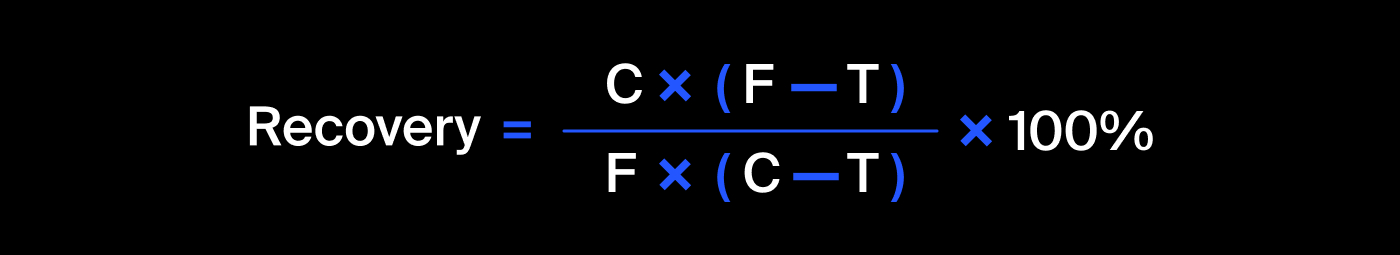

Where: 

C is the percentage of gold in the concentrate after flotation/purification; 

F is the percentage of gold in the raw material/concentrate before flotation/purification; 

T is the percentage of gold in the tailings after flotation/purification. 

To predict the coefficient, it is necessary to find the percentage of gold in the concentrates and tailings. Not only the final product, but also the rough concentrate is important.

### Quality metric.

We introduce a new quality metric, sMAPE (Symmetric Mean Absolute Percentage Error), to solve the task.

It is similar to MAE, but expressed in relative rather than absolute values. Why is it symmetric? It takes into account the scale of both the target feature and the prediction equally.

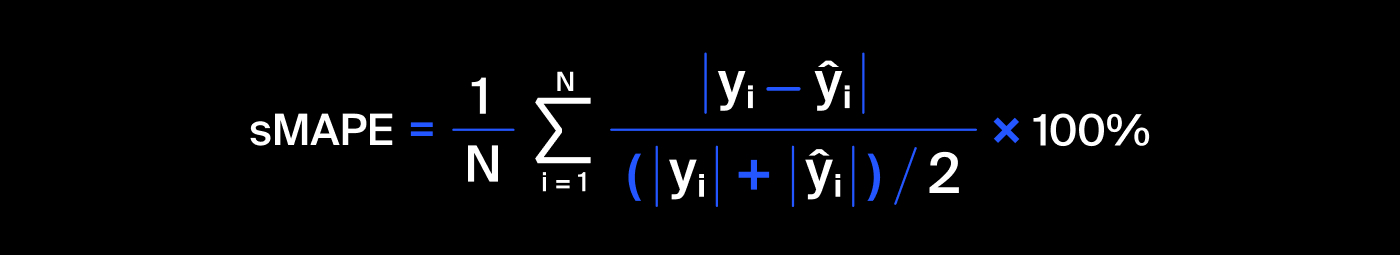



Description:

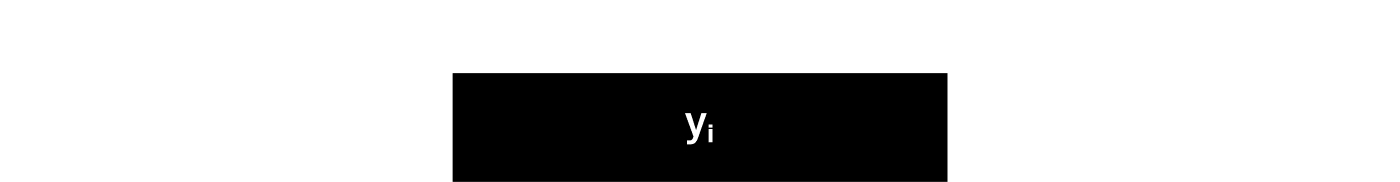

The target feature value for the object with the ordinal number i in the sample, on which the quality is measured.

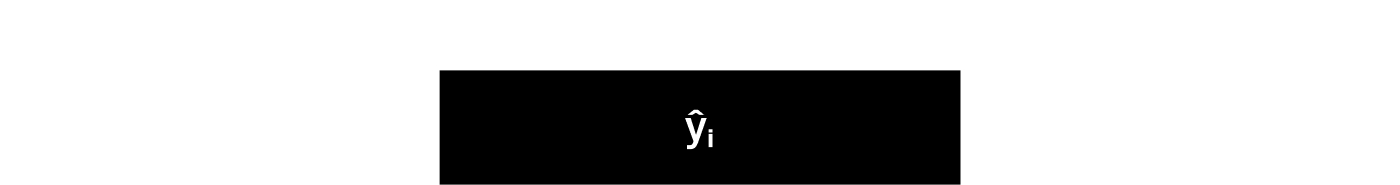

The prediction value for the object with the ordinal number i, for example, in the test sample. 

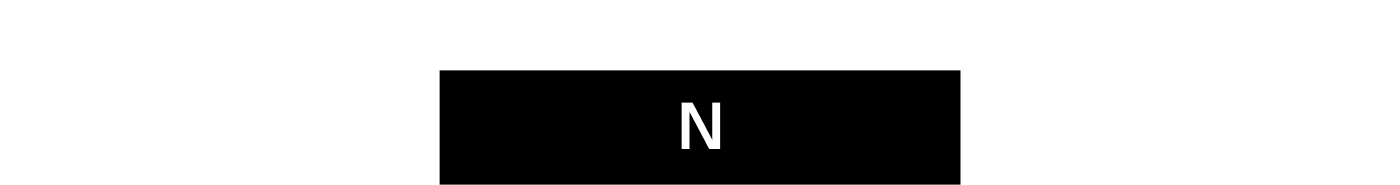

The number of objects in the sample.

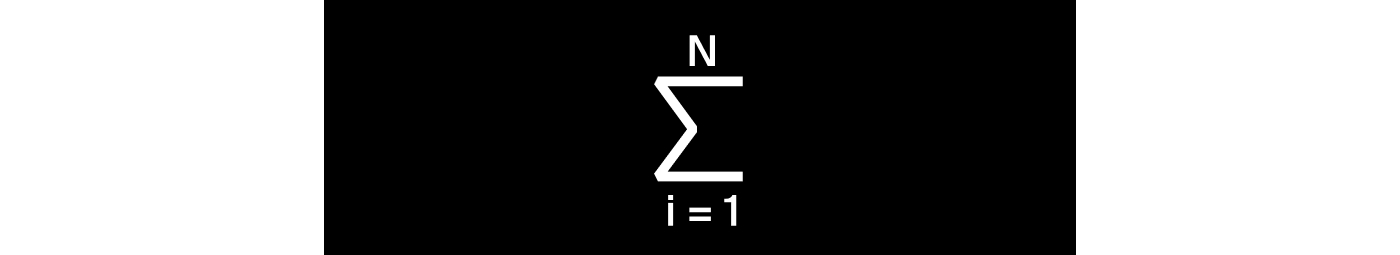

Summation over all objects in the sample (i changes from 1 to N). 

We need to forecast two values at once:

the efficiency of enrichment of the rougher concentrate rougher.output.recovery; 

the efficiency of enrichment of the final concentrate final.output.recovery. 

The final metric is composed of two values:

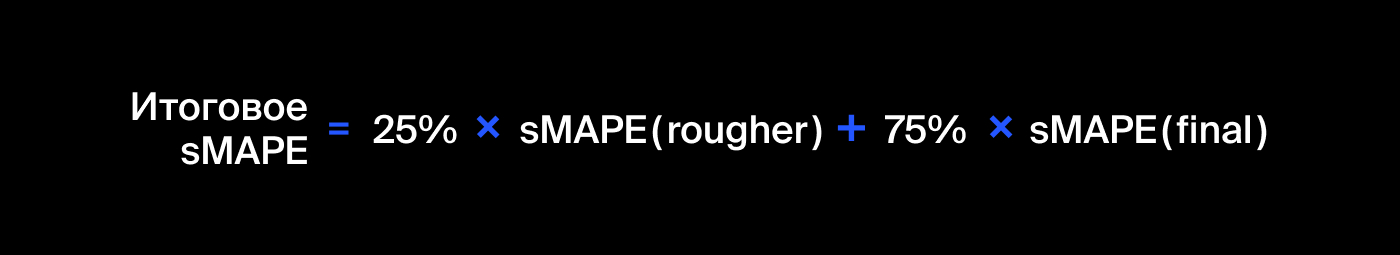

## Plan of the project:
1. Prepare the data.
- 1.1. Open the files and study them.
- 1.2. Check that the enrichment efficiency is calculated correctly. Calculate it on the training sample for the rougher.output.recovery feature. Find the MAE between your calculations and the feature value. Describe the conclusions.
- 1.3. Analyze the features that are not available in the test sample.
- 1.4. Perform data preprocessing.
2. Analyze the data.
- 2.1. Look at how the concentration of metals (Au, Ag, Pb) changes at different stages of purification. Describe the conclusions.
- 2.2. Compare the distribution of raw material granule sizes on the training and test samples. If the distributions differ significantly from each other, the model estimation will be incorrect.
- 2.3. Investigate the total concentration of all substances at different stages: in raw material, in concentrate and in final concentrate.
3. Build the model.
- 3.1. Write a function to calculate the final sMAPE.
- 3.2. Train different models and evaluate their quality with cross-validation. Select the best model and check it on the test sample. Describe the conclusions.
4. Write a general conclusion.

## 1. Reviewing and preprocessing of the data.

In [2]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

In [4]:
from catboost import CatBoostRegressor
from catboost import cv, Pool

In [5]:
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:,.2f}'.format

Let's load the data.

In [6]:
url_1 = 'https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv'
url_2 = 'https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv'
url_3 = 'https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv'

train = pd.read_csv(url_1)
test = pd.read_csv(url_2)
data = pd.read_csv(url_3)

Let's look at the datasets.

In [7]:
train.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,...,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",...,-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",...,-450.87,"1,399.72",-450.12,14.27,4.59,9.00,2.49,25.88,-499.99,23.89,-500.37,23.97,-500.09,22.09,-499.45,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,123.82,11.32,7.25,0.99,8.60,10.35,19.17,33.97,16.49,3.12,6.47,2.42,"1,601.56",-500.00,"1,600.39",...,-449.94,"1,400.32",-450.53,14.12,4.62,8.84,2.46,26.01,-499.93,23.89,-499.95,23.91,-499.44,23.96,-499.90,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43


In [8]:
test.head(3)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.80,14.99,8.08,1.01,"1,398.98",-500.23,"1,399.14",-499.92,"1,400.10",-500.70,"1,399.00",-499.49,13.13,5.64,489.79,62.71,42.02,12.08,16.92,6.15,16.87,6.15,"1,001.85",-350.30,...,-399.40,"1,198.29",-399.49,999.47,-399.53,949.57,-398.18,24.94,-500.49,14.95,-500.01,20.02,-450.40,13.99,-449.83,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
1,2016-09-01 01:59:59,215.39,14.99,8.08,0.99,"1,398.78",-500.06,"1,398.06",-499.78,"1,396.15",-499.24,"1,399.51",-500.42,13.04,5.53,490.10,61.96,41.19,11.92,17.00,6.00,17.00,6.00,998.69,-350.43,...,-399.63,"1,200.51",-399.94,"1,000.00",-399.49,950.20,-405.79,24.92,-499.81,14.93,-500.76,19.99,-450.11,14.09,-450.06,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2,2016-09-01 02:59:59,215.26,12.88,7.79,1.00,"1,398.49",-500.87,"1,398.86",-499.76,"1,398.08",-502.15,"1,399.50",-499.72,13.14,5.43,489.62,66.90,42.55,12.09,16.99,5.85,16.98,5.85,998.52,-349.78,...,-401.07,"1,199.77",-400.79,999.93,-399.24,950.32,-400.86,24.91,-500.30,15.00,-500.99,20.04,-450.26,14.08,-449.66,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62


In [9]:
data.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,...,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",...,-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",...,-450.87,"1,399.72",-450.12,14.27,4.59,9.00,2.49,25.88,-499.99,23.89,-500.37,23.97,-500.09,22.09,-499.45,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,123.82,11.32,7.25,0.99,8.60,10.35,19.17,33.97,16.49,3.12,6.47,2.42,"1,601.56",-500.00,"1,600.39",...,-449.94,"1,400.32",-450.53,14.12,4.62,8.84,2.46,26.01,-499.93,23.89,-499.95,23.91,-499.44,23.96,-499.90,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43


Let's look at the missing values.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [11]:
train.isna().mean().sort_values(ascending=False)

secondary_cleaner.output.tail_sol          0.11
rougher.state.floatbank10_e_air            0.03
rougher.input.floatbank11_xanthate         0.03
primary_cleaner.output.concentrate_sol     0.02
secondary_cleaner.state.floatbank2_a_air   0.02
                                           ... 
rougher.output.concentrate_pb              0.00
rougher.output.concentrate_au              0.00
rougher.output.recovery                    0.00
rougher.output.tail_pb                     0.00
date                                       0.00
Length: 87, dtype: float64

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [13]:
test.isna().mean().sort_values(ascending=False)

rougher.input.floatbank11_xanthate           0.00
rougher.input.feed_sol                       0.00
secondary_cleaner.state.floatbank3_a_air     0.00
rougher.input.floatbank11_sulfate            0.00
primary_cleaner.input.depressant             0.00
rougher.input.floatbank10_sulfate            0.00
primary_cleaner.input.xanthate               0.00
primary_cleaner.input.sulfate                0.00
rougher.input.feed_rate                      0.00
secondary_cleaner.state.floatbank2_a_air     0.00
secondary_cleaner.state.floatbank2_b_air     0.00
rougher.input.feed_size                      0.00
secondary_cleaner.state.floatbank2_b_level   0.00
rougher.state.floatbank10_f_level            0.00
rougher.state.floatbank10_f_air              0.00
secondary_cleaner.state.floatbank3_a_level   0.00
secondary_cleaner.state.floatbank2_a_level   0.00
date                                         0.00
rougher.state.floatbank10_e_air              0.00
secondary_cleaner.state.floatbank3_b_air     0.00


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [15]:
data.isna().mean().sort_values(ascending=False)

secondary_cleaner.output.tail_sol          0.09
rougher.input.floatbank11_xanthate         0.02
rougher.state.floatbank10_e_air            0.02
primary_cleaner.output.concentrate_sol     0.02
secondary_cleaner.state.floatbank2_a_air   0.01
                                           ... 
rougher.state.floatbank10_d_level          0.00
rougher.state.floatbank10_d_air            0.00
rougher.output.tail_pb                     0.00
rougher.output.tail_sol                    0.00
date                                       0.00
Length: 87, dtype: float64

Let's look at the duplicates.

In [16]:
print('Count the duplicates train:', train.duplicated().sum())
print('Count the duplicates test:', test.duplicated().sum())
print('Count the duplicates data:', data.duplicated().sum())

Count the duplicates train: 0
Count the duplicates test: 0
Count the duplicates data: 0


No duplicates found.

### Check the enrichment efficiency.

In [17]:
train_temp = train.copy(deep=True)

C = train_temp['rougher.output.concentrate_au']
F = train_temp['rougher.input.feed_au']
T = train_temp['rougher.output.tail_au']

train_temp['rougher.output.recovery.checked'] = (C * (F - T)) / (F * (C - T)) * 100

train_temp.dropna(inplace=True)

In [18]:
print('MAE:', mean_absolute_error(train_temp['rougher.output.recovery'], train_temp['rougher.output.recovery.checked']))

MAE: 9.82970122149377e-15


The mean absolute deviation is insignificantly small, so the enrichment efficiency is calculated correctly.

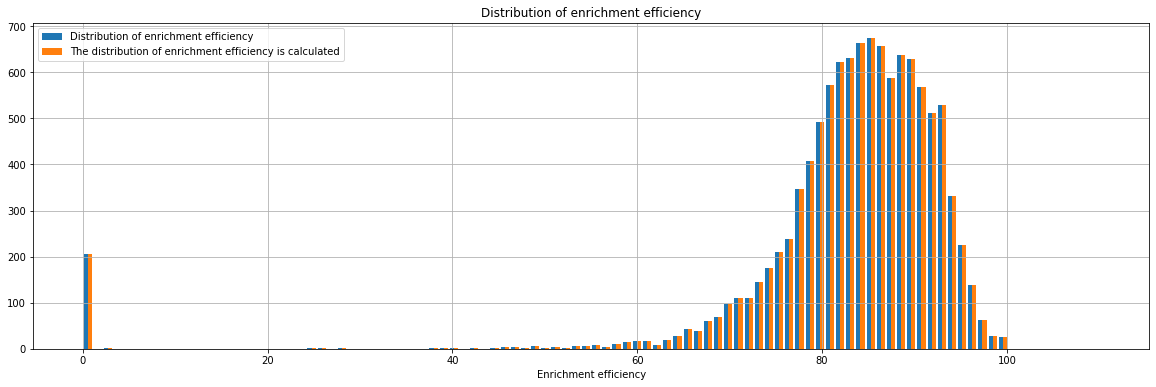

In [19]:
plt.subplots(figsize=(20,6))

a = train_temp['rougher.output.recovery']
b = train_temp['rougher.output.recovery.checked']

plt.hist([a, b], 
         bins=100, 
         range=(0, 110), 
         label=['Distribution of enrichment efficiency', 'The distribution of enrichment efficiency is calculated'])
plt.legend(loc='upper left')
plt.title('Distribution of enrichment efficiency')
plt.xlabel('Enrichment efficiency')
plt.grid(True)
plt.show()

As we can see from the distribution graph, the enrichment efficiency does not differ from the calculated one. Also, the mean absolute deviation is insignificantly small, so the enrichment efficiency is calculated correctly. 

We noticed the number of data with zero values, which are not provided in the process. We will deal with this anomaly later.

### We will analyze the features that are not available in the test sample.

Let's look at the differences between the training and test samples.

In [20]:
set(train) - set(test)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

As we can see, the output parameters of the product and the calculation characteristics are absent in the test sample. The parameters are not available because they are measured and/or calculated much later. 

The target features are missing: rougher.output.recovery and final.output.recovery, which can be restored from full.

Additionally, let's look at the differences between the full dataset and the training samples.

In [21]:
set(data) - set(train)

set()

No differences found.

### Preprocessing.

We will prepare the data in the dataframe data with the full set of data.

In [22]:
full_target_rougher = data['rougher.output.recovery']
full_target_final = data['final.output.recovery']
full_features = data.drop(['final.output.recovery','rougher.output.recovery'], axis=1)

full_features.ffill(axis=0,
                    inplace=True)

full_features['rougher.output.recovery'] = full_target_rougher
full_features['final.output.recovery'] = full_target_final
data = full_features.dropna()
data.reset_index(inplace=True, 
                 drop = True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19439 non-null  float64
 2   final.output.concentrate_pb                         19439 non-null  float64
 3   final.output.concentrate_sol                        19439 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.tail_ag                                19439 non-null  float64
 6   final.output.tail_pb                                19439 non-null  float64
 7   final.output.tail_sol                               19439 non-null  float64
 8   final.output.tail_au                                19439 non-null  float64


We will prepare the data in the train dataframe with the training sample.

In [24]:
train_target_rougher = train['rougher.output.recovery']
train_target_final = train['final.output.recovery']
train_features = train.drop(['final.output.recovery',
                             'rougher.output.recovery'], 
                            axis=1)

train_features.ffill(axis=0,
                     inplace=True)

train_features['rougher.output.recovery'] = train_target_rougher
train_features['final.output.recovery'] = train_target_final
train = train_features.dropna()
train.reset_index(inplace=True, 
                  drop = True)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14149 non-null  float64
 2   final.output.concentrate_pb                         14149 non-null  float64
 3   final.output.concentrate_sol                        14149 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                                14149 non-null  float64


We will prepare the data in the test dataframe with the test sample.

In [26]:
test = test.ffill(axis=0)

test = test.merge(right = data[['final.output.recovery', 'date']], 
                  how='left', 
                  on='date')
test = test.merge(right = data[['rougher.output.recovery', 'date']], 
                  how='left', 
                  on='date')
test = test.dropna()

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5290 non-null   float64
 2   primary_cleaner.input.depressant            5290 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

We see the imbalance in the features in the training and test samples 87 to 55, let's fix it.

In [28]:
print('Train sample', train.shape)
print('Test sample', test.shape)

Train sample (14149, 87)
Test sample (5290, 55)


From the training sample, we will remove the features that are absent in the test.

In [29]:
train = train[list(test.columns)]

In [30]:
print('Train sample', train.shape)
print('Test sample', test.shape)

Train sample (14149, 55)
Test sample (5290, 55)


Conclusion: 

Upon reviewing the data, it was found that:
* There were missing data in all datasets.
* There was an imbalance of features between the training and test samples.
* The efficiency of enrichment was calculated correctly based on graphical interpretation and calculation.
* No errors or duplicates were found.
* The missing datasets were filled.
* The imbalance of features in the training and test samples was corrected.
* During the assessment of the correctness of enrichment, data with zero values were identified. According to the technical process, this is an anomaly, which will be further examined in the following data preparation steps.

## 2. EDA.

Let's look at how the concentration of metals (Au, Ag, Pb) changes at different stages of purification.

In [31]:
au_conc = data[['rougher.output.concentrate_au',
                'primary_cleaner.output.concentrate_au',
                'final.output.concentrate_au']]

ag_conc = data[['rougher.output.concentrate_ag',
                'primary_cleaner.output.concentrate_ag',
                'final.output.concentrate_ag']]

pb_conc = data[['rougher.output.concentrate_pb',
                'primary_cleaner.output.concentrate_pb',
                'final.output.concentrate_pb']]

Text(0.5, 1.0, 'Plumbum')

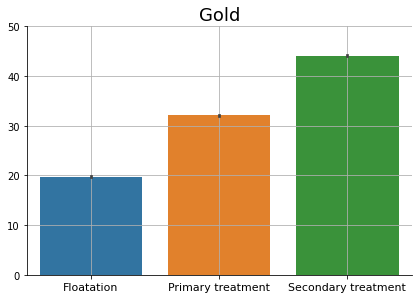

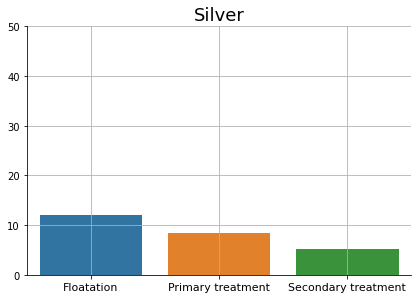

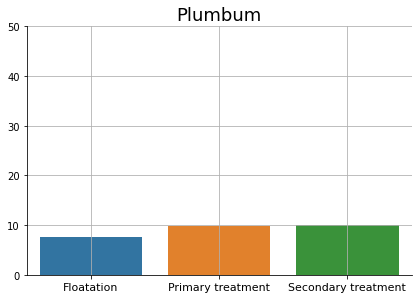

In [32]:
sns.catplot(data=au_conc, 
            kind ='bar', 
            height=4, 
            aspect=1.5
            ).set_xticklabels(['Floatation',
                               'Primary treatment',
                               'Secondary treatment'], 
                              fontsize=11)
plt.ylim(0, 50)
plt.grid(True)
plt.title('Gold', 
          fontsize=18) 

sns.catplot(data=ag_conc, 
            kind ='bar', 
            height=4, 
            aspect=1.5
            ).set_xticklabels(['Floatation',
                               'Primary treatment',
                               'Secondary treatment'], 
                              fontsize=11)
plt.ylim(0, 50)
plt.grid(True)
plt.title('Silver', 
          fontsize=18)

sns.catplot(data=pb_conc, 
            kind ='bar', 
            height=4, 
            aspect=1.5
            ).set_xticklabels(['Floatation',
                               'Primary treatment',
                               'Secondary treatment'], 
                              fontsize=11)
plt.ylim(0, 50)
plt.grid(True)
plt.title('Plumbum', 
          fontsize=18) 

Let's look at the concentration of metals on the range diagrams.

Text(0.5, 1.0, 'Plumbum')

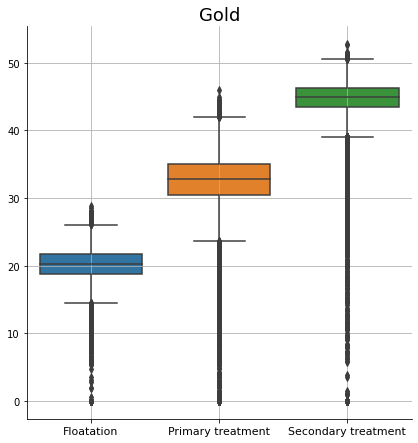

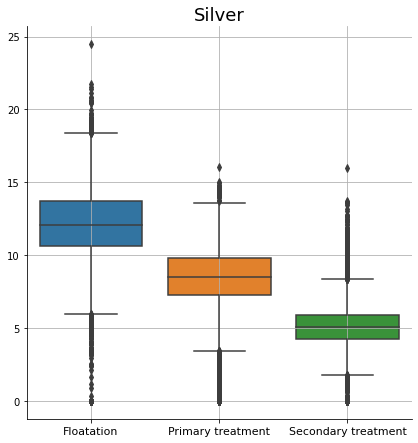

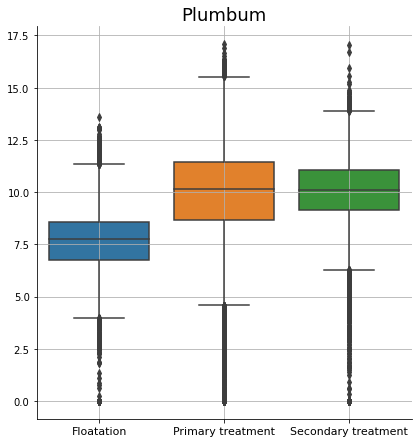

In [33]:
sns.catplot(data=au_conc, 
            kind ='box', 
            height=6
            ).set_xticklabels(['Floatation',
                               'Primary treatment',
                               'Secondary treatment'], 
                              fontsize=11)
plt.grid(True)
plt.title('Gold', fontsize=18) 

sns.catplot(data=ag_conc, 
            kind ='box', 
            height=6
            ).set_xticklabels(['Floatation',
                               'Primary treatment',
                               'Secondary treatment'], 
                              fontsize=11)
plt.grid(True)
plt.title('Silver', fontsize=18)

sns.catplot(data=pb_conc, 
            kind ='box', 
            height=6
            ).set_xticklabels(['Floatation',
                               'Primary treatment',
                               'Secondary treatment'], 
                              fontsize=11)
plt.grid(True)
plt.title('Plumbum', fontsize=18) 

We see that the concentration of metals changes from stage to stage and there is no violation of logic. Since this is gold mining, the concentration of gold increases from stage to stage, and the tails in the form of silver and lead decrease.

### Let's compare the distributions of raw material granule sizes on the training and test samples.

The size of the granules before flotation on the training and test samples.

In [34]:
rifs = pd.concat([train['rougher.input.feed_size'], 
                  test['rougher.input.feed_size']], 
                 axis=1) 
rifs.columns = ['train', 'test']
rifs.describe()

,train,test
count,"14,149.00","5,290.00"
mean,60.24,55.95
std,23.01,19.08
min,9.66,0.05
25%,48.97,43.91
50%,55.27,50.85
75%,66.01,62.45
max,484.97,392.49


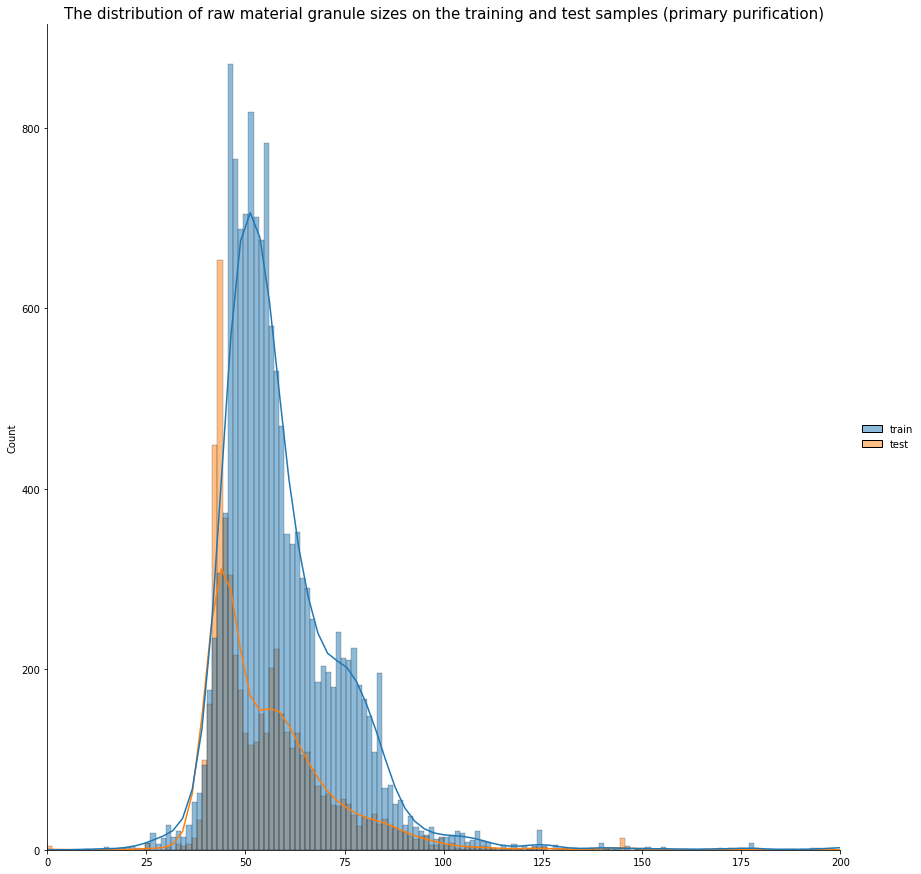

In [35]:
sns.displot(rifs, 
            legend=True, 
            kde=True, 
            height=12)

plt.title('The distribution of raw material granule sizes on the training and test samples (primary purification)', 
          fontsize=15)

plt.xlim([0, 200])
plt.show()

The size of the granules before primary purification on the training and test samples.

In [36]:
pcifs = pd.concat([train['primary_cleaner.input.feed_size'],
                   test['primary_cleaner.input.feed_size']], 
                  axis=1) 

pcifs.columns = ['train', 'test']
pcifs.describe()

,train,test
count,"14,149.00","5,290.00"
mean,7.32,7.27
std,0.61,0.61
min,1.08,5.65
25%,6.96,6.89
50%,7.29,7.25
75%,7.70,7.60
max,10.47,15.50


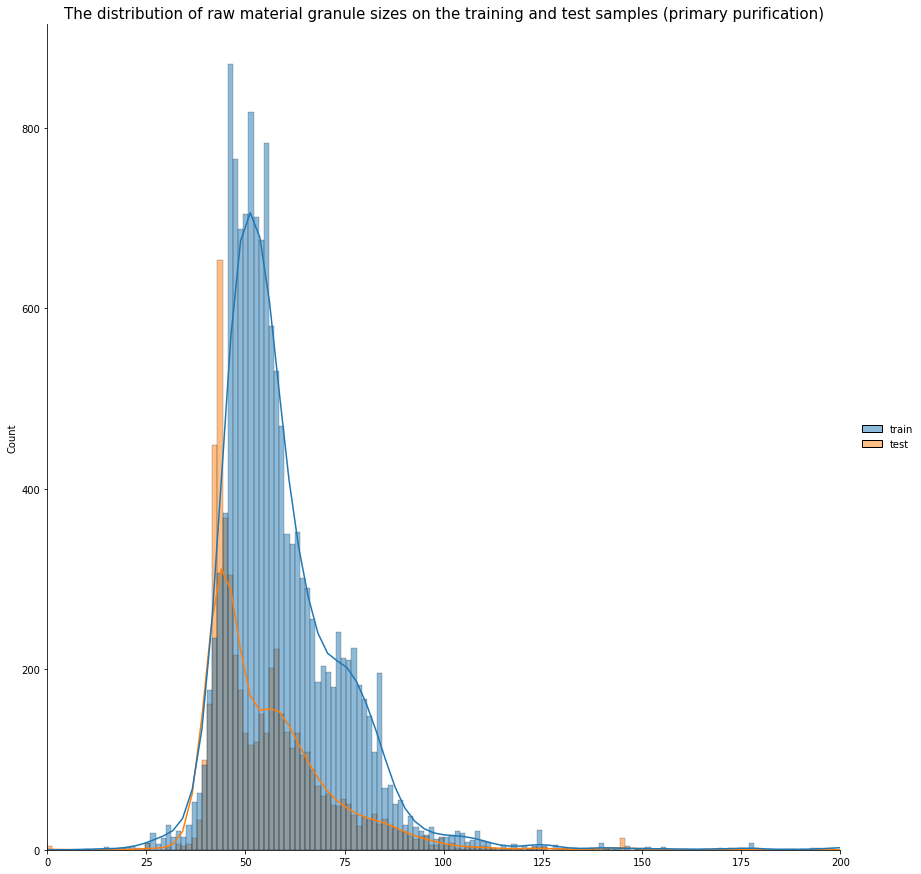

In [37]:
sns.displot(rifs, 
            legend=True, 
            kde=True, 
            height=12)

plt.title('The distribution of raw material granule sizes on the training and test samples (primary purification)', 
          fontsize=15)

plt.xlim([0, 200])
plt.show()

Conclusion: The distributions of raw material granule sizes on the training and test samples are slightly different, we see this from the average values, medians and quartiles, as well as on the graphs, the differences should not affect the assessment of the model.

### Let's investigate the total concentration of all substances at different stages: in the raw material, in the rough and final concentrates.

In [38]:
data['raw'] = data[['rougher.input.feed_au', 
                    'rougher.input.feed_ag', 
                    'rougher.input.feed_pb', 
                    'rougher.input.feed_sol']
                   ].sum(axis=1)

data['rough concentrate'] = data[['rougher.output.concentrate_au', 
                                  'rougher.output.concentrate_ag', 
                                  'rougher.output.concentrate_pb', 
                                  'rougher.output.concentrate_sol']
                                 ].sum(axis=1)

data['primary concentrate'] = data[['primary_cleaner.output.concentrate_au',
                                    'primary_cleaner.output.concentrate_ag', 
                                    'primary_cleaner.output.concentrate_pb', 
                                    'primary_cleaner.output.concentrate_sol']
                                   ].sum(axis=1)

data['final concentrate'] = data[['final.output.concentrate_au', 
                                  'final.output.concentrate_ag', 
                                  'final.output.concentrate_pb', 
                                  'final.output.concentrate_sol']
                                 ].sum(axis=1)

In [39]:
data[['raw', 
      'rough concentrate', 
      'primary concentrate', 
      'final concentrate']
     ].describe()

,raw,rough concentrate,primary concentrate,final concentrate
count,"19,439.00","19,439.00","19,439.00","19,439.00"
mean,57.32,68.17,60.76,68.65
std,7.21,12.49,10.02,7.43
min,0.04,0.00,0.00,0.00
25%,53.56,66.01,58.93,67.93
50%,57.59,70.18,62.50,69.60
75%,61.95,74.36,65.67,71.37
max,76.98,88.14,80.75,80.21


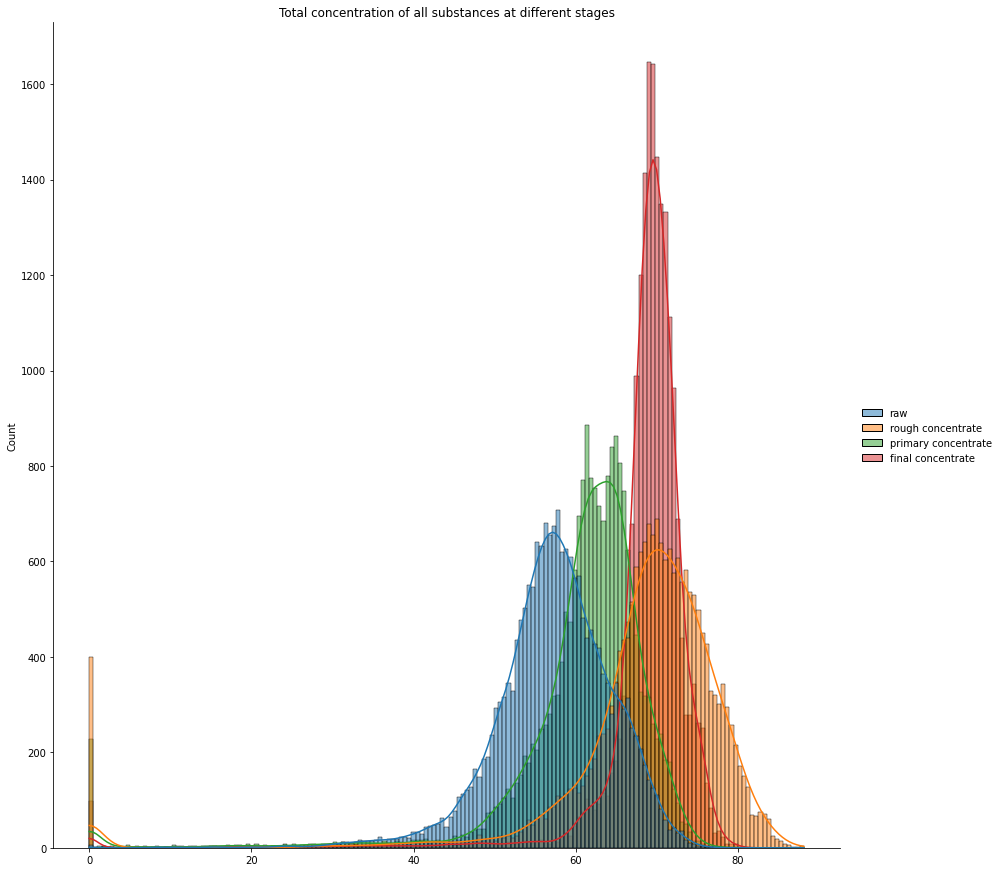

In [40]:
sns.displot(data[['raw', 
                  'rough concentrate', 
                  'primary concentrate', 
                  'final concentrate']], 
            legend=True, 
            kde=True, 
            height=12)  

plt.title('Total concentration of all substances at different stages', 
          fontsize=12)

plt.show()

We will look at the number of zero values.

In [41]:
anomaly_data = len(data[data['rough concentrate'] == 0]) + len(data[data['primary concentrate'] == 0]) + len(data[data['final concentrate'] == 0])
print('The number of anomalous data', anomaly_data,
      '; The proportion of anomalous data:', round(anomaly_data/len(data), 2))

The number of anomalous data 600 ; The proportion of anomalous data: 0.03


We will remove objects with zero values.

In [42]:
data_good = data[
    (data['raw'] >  0) & 
    (data['rough concentrate'] > 0) & 
    (data['primary concentrate'] > 0) & 
    (data['final concentrate'] > 0)
    ].reset_index(drop=True)

In [43]:
data_good[['raw', 
           'rough concentrate', 
           'primary concentrate', 
           'final concentrate']
          ].describe()

,raw,rough concentrate,primary concentrate,final concentrate
count,"18,848.00","18,848.00","18,848.00","18,848.00"
mean,57.32,69.59,61.08,69.01
std,7.17,7.76,8.89,5.54
min,0.04,0.04,0.04,0.04
25%,53.53,66.33,59.01,67.95
50%,57.60,70.31,62.49,69.60
75%,61.96,74.45,65.64,71.37
max,76.98,88.14,80.75,80.21


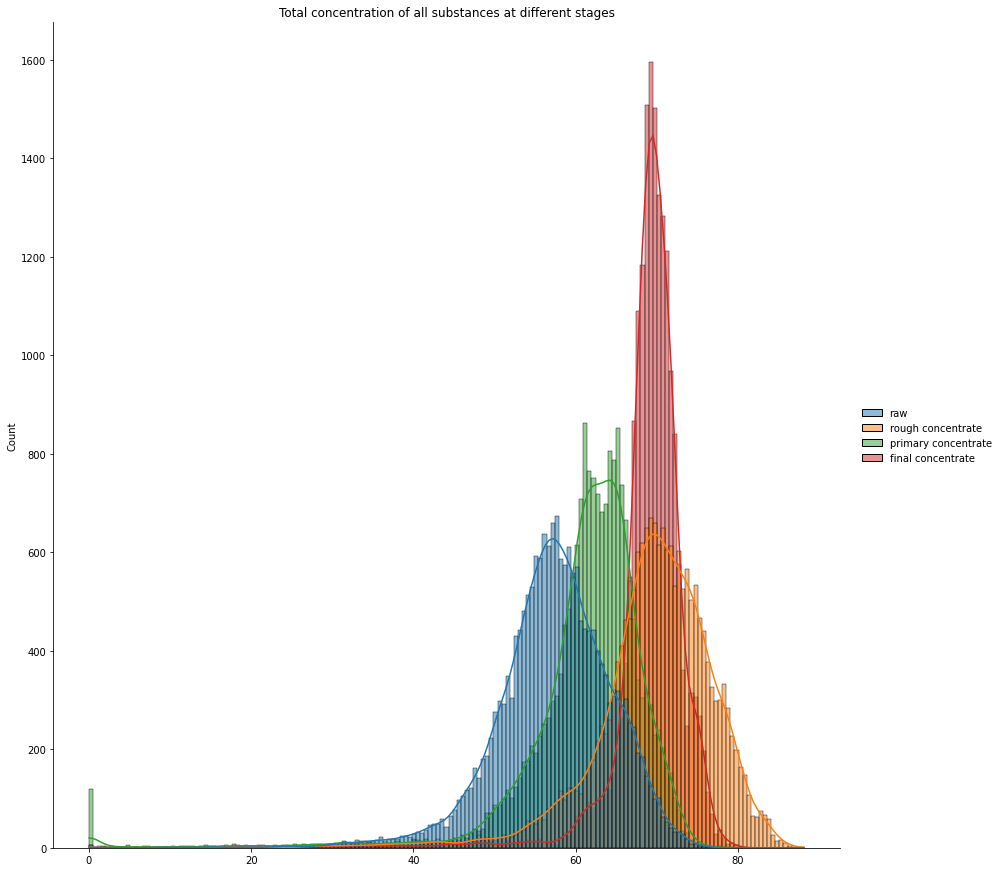

In [44]:
sns.displot(data_good[['raw', 
                       'rough concentrate', 
                       'primary concentrate', 
                       'final concentrate']], 
            legend=True, 
            kde=True, 
            height=12)  

plt.title('Total concentration of all substances at different stages', 
          fontsize=12)

plt.show()

Let's take a closer.

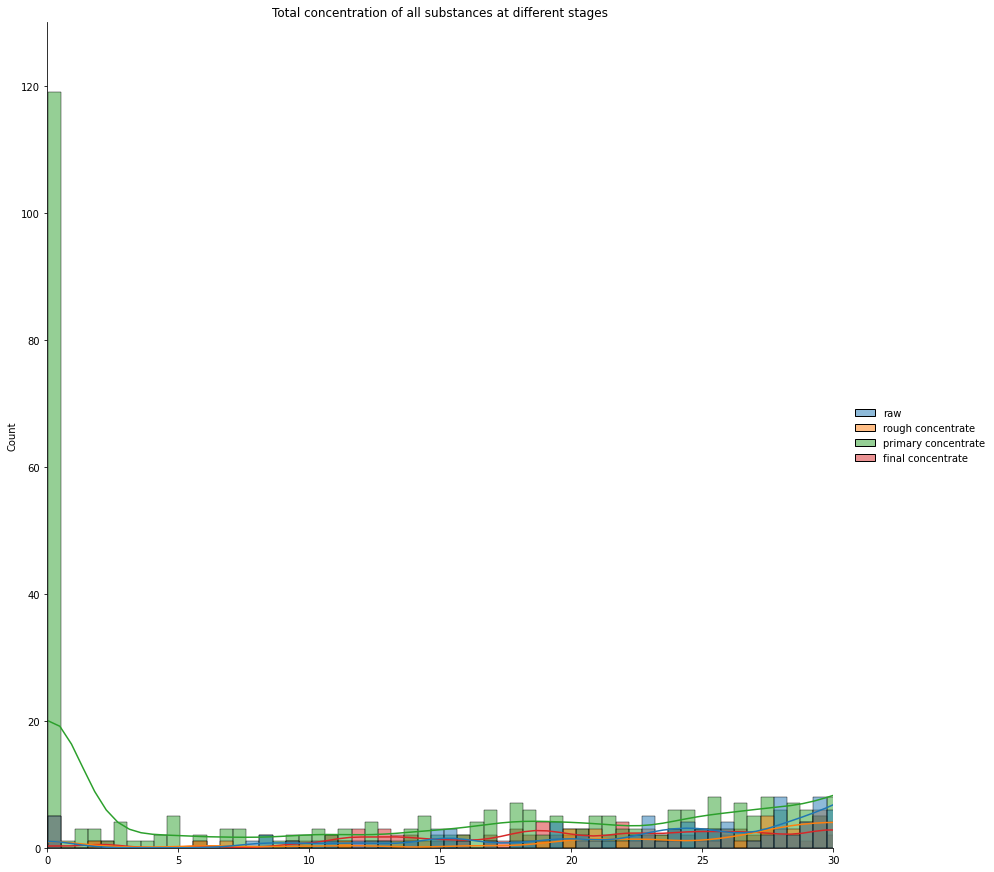

In [45]:
sns.displot(data_good[['raw', 
                       'rough concentrate', 
                       'primary concentrate', 
                       'final concentrate']], 
            legend=True, 
            kde=True, 
            height=12)
  
plt.title('Total concentration of all substances at different stages', 
          fontsize=12)

plt.xlim(0, 30)
plt.ylim(0, 130)
plt.show()

We can see the absence of zero values.

We will remove the identified anomalous data from the training and test samples.

In [46]:
train_good = train[train['date'].isin(data_good['date'])].reset_index(drop=True)
test_good = test[test['date'].isin(data_good['date'])].reset_index(drop=True)

In [47]:
print('data', data_good.shape)
print('train', train_good.shape)
print('test', test_good.shape)

data (18848, 91)
train (13725, 55)
test (5123, 55)


Conclusion: 
* The change in metal concentration (Au, Ag, Pb) at different stages of purification was checked and it was seen that the metal concentration changes from stage to stage and there is no logic violation. As this is gold mining, the gold concentration increases from stage to stage while the tails in the form of silver and lead decrease. 
* The distributions of raw material granule sizes in the training and test samples differ slightly, as seen from the mean values, medians and quartiles, and also observed in the graphs, the differences should not affect the model assessment. 
* The total concentration of all substances at different stages was studied, anomalous data with zero values were identified, these data make up 3% and were removed. 
* The data is prepared for further model training.

## 3. Model.

Let's write a function for calculating the model quality metric - sMAPE (Symmetric Mean Absolute Percentage Error).

In [48]:
def smape (target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

Also, let's write a function for calculating the final sMAPE.

In [49]:
def total_smape (rougher, final):
    return 0.25 * rougher + 0.75 * final

We will prepare features and target for the training and test sets.

In [50]:
#train
target_rougher_train = train_good['rougher.output.recovery']
target_final_train = train_good['final.output.recovery']
features_train = train_good.drop(['date', 
                                  'rougher.output.recovery', 
                                  'final.output.recovery'], 
                                 axis=1)

#test
target_rougher_test = test_good['rougher.output.recovery']
target_final_test = test_good['final.output.recovery']
features_test = test_good.drop(['date', 
                                'rougher.output.recovery', 
                                'final.output.recovery'], 
                               axis=1)

We will scale the features.

In [51]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

We will check several models by cross-validation on the default global parameters and select the best result.

We will train and evaluate the linear regression model.

In [52]:
scorer = make_scorer(smape, 
                     greater_is_better=False) 
    
cross_val_score_rougher_lr = cross_val_score(LinearRegression(),
                                             features_train,
                                             target_rougher_train,
                                             cv=5, 
                                             scoring=scorer)

cross_val_score_final_lr = cross_val_score(LinearRegression(),
                                           features_train,
                                           target_final_train,
                                           cv=5, 
                                           scoring=scorer)

In [53]:
print('rougher', cross_val_score_rougher_lr.mean())
print('final', cross_val_score_final_lr.mean())
print('mean', ((cross_val_score_rougher_lr.mean() + cross_val_score_final_lr.mean())/2))

rougher -7.265696047565989
final -10.950532500993141
mean -9.108114274279565


We will train and evaluate the decision tree regression model.

In [ ]:
model_dt = DecisionTreeRegressor(random_state=12345)

splitter = ['best', 'random']
max_features = ['log2', 'sqrt', 'auto']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 100)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50)]

param_dist = {'splitter': splitter,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rs = RandomizedSearchCV(model_dt, 
                        param_dist, 
                        random_state=12345, 
                        scoring=scorer)

rs_rougher = rs.fit(features_train, target_rougher_train)

rs_final = rs.fit(features_train, target_final_train)

best_model_rs_rougher = DecisionTreeRegressor(random_state=12345, 
                                              **rs_rougher.best_params_)

best_model_rs_final = DecisionTreeRegressor(random_state=12345, 
                                            **rs_final.best_params_)

cross_val_score_rougher_dt = cross_val_score(best_model_rs_rougher,
                                             features_train,
                                             target_rougher_train,
                                             cv=5, 
                                             scoring=scorer)

cross_val_score_final_dt = cross_val_score(best_model_rs_final,
                                           features_train,
                                           target_final_train,
                                           cv=5, 
                                           scoring=scorer)

In [55]:
print('Optimal combination of hyperparameters for target_rougher_train:', rs_rougher.best_params_)
print('Optimal combination of hyperparameters for target_final_train:', rs_final.best_params_)

Optimal combination of hyperparameters for target_rougher_train: {'splitter': 'random', 'min_samples_split': 43, 'min_samples_leaf': 23, 'max_features': 'log2', 'max_depth': 11}
Optimal combination of hyperparameters for target_final_train: {'splitter': 'random', 'min_samples_split': 43, 'min_samples_leaf': 23, 'max_features': 'log2', 'max_depth': 11}


In [56]:
print('rougher', cross_val_score_rougher_dt.mean())
print('final', cross_val_score_final_dt.mean())
print('mean', ((cross_val_score_rougher_dt.mean() + cross_val_score_final_dt.mean())/2))

rougher -8.407099971215052
final -10.498761742849496
mean -9.452930857032275


We will train and evaluate the CatBoost model.

In [ ]:
model_cb_rougher = CatBoostRegressor(random_seed=12345, 
                                     early_stopping_rounds=200)

model_cb_final = CatBoostRegressor(random_seed=12345, 
                                   early_stopping_rounds=200)

learning_rate = [float(x) for x in np.linspace(start = 0.03, stop = 0.5)]
depth = [int(x) for x in np.linspace(start = 6, stop = 50)]
iterations = [int(x) for x in np.linspace(start = 100, stop = 1000)]

param_dist = {'learning_rate': learning_rate,
              'depth': depth,
              'iterations': iterations}

rs_rougher = model_cb_rougher.randomized_search(param_dist, 
                                                features_train, 
                                                target_rougher_train)

rs_final = model_cb_final.randomized_search(param_dist, 
                                            features_train, 
                                            target_final_train)

best_model_cb_rougher = CatBoostRegressor(random_state=12345, 
                                          **rs_rougher['params'])

best_model_cb_final = CatBoostRegressor(random_state=12345, 
                                        **rs_final['params'])

cross_val_score_rougher_cb = cross_val_score(best_model_cb_rougher,
                                             features_train,
                                             target_rougher_train,
                                             cv=5, 
                                             scoring=scorer)

cross_val_score_final_cb = cross_val_score(best_model_cb_final,
                                           features_train,
                                           target_final_train,
                                           cv=5, 
                                           scoring=scorer)

In [58]:
print('Optimal combination of hyperparameters for target_rougher_train:', rs_rougher['params'])
print('Optimal combination of hyperparameters for target_final_train:', rs_final['params'])

Optimal combination of hyperparameters for target_rougher_train: {'depth': 11, 'iterations': 393, 'learning_rate': 0.336938775510204}
Optimal combination of hyperparameters for target_final_train: {'depth': 11, 'iterations': 393, 'learning_rate': 0.336938775510204}


In [59]:
print('rougher', cross_val_score_rougher_cb.mean())
print('final', cross_val_score_final_cb.mean())
print('mean',((cross_val_score_rougher_cb.mean() + cross_val_score_final_cb.mean())/2))

rougher -6.202538050054377
final -9.482546483155554
mean -7.842542266604966


We will train and evaluate the random forest model.

In [60]:
model_rf = RandomForestRegressor(random_state=12345)

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 100)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rs = RandomizedSearchCV(model_rf, 
                        param_dist, 
                        random_state=12345, 
                        scoring=scorer)

rs_rougher = rs.fit(features_train, target_rougher_train)

rs_final = rs.fit(features_train, target_final_train)

best_model_rf_rougher = RandomForestRegressor(random_state=12345, 
                                              **rs_rougher.best_params_)

best_model_rf_final = RandomForestRegressor(random_state=12345, 
                                            **rs_final.best_params_)

cross_val_score_rougher_rr = cross_val_score(best_model_rf_rougher, 
                                             features_train, 
                                             target_rougher_train,
                                             cv=5, 
                                             scoring=scorer)

cross_val_score_final_rr = cross_val_score(best_model_rf_final, 
                                           features_train, 
                                           target_final_train, 
                                           cv=5, 
                                           scoring=scorer)

In [61]:
print('Optimal combination of hyperparameters for target_rougher_train:', rs_rougher.best_params_)
print('Optimal combination of hyperparameters for target_final_train:', rs_final.best_params_)

Optimal combination of hyperparameters for target_rougher_train: {'n_estimators': 74, 'min_samples_split': 14, 'min_samples_leaf': 43, 'max_features': 'sqrt', 'max_depth': 55, 'bootstrap': True}
Optimal combination of hyperparameters for target_final_train: {'n_estimators': 74, 'min_samples_split': 14, 'min_samples_leaf': 43, 'max_features': 'sqrt', 'max_depth': 55, 'bootstrap': True}


The models were launched with hyperparameter selection through RandomizedSearchCV. The result almost doubled the accuracy of the models.

In [62]:
print('rougher', cross_val_score_rougher_rr.mean())
print('final', cross_val_score_final_rr.mean())
print('mean', ((cross_val_score_rougher_rr.mean() + cross_val_score_final_rr.mean())/2))

rougher -5.961114502673341
final -8.952891104164332
mean -7.4570028034188365


We see that the best result is given by the CatBoost model with an average cross-validation score of 0.0937, but we will also see how the random forest model will perform on the test set. We will give the random forest model a chance.

We will train and evaluate the CatBoost model on the test set.

In [ ]:
model_cb_rougher = best_model_cb_rougher.fit(features_train, target_rougher_train)
model_cb_final = best_model_cb_final.fit(features_train, target_final_train)

cb_predictions_rougher = model_cb_rougher.predict(features_test)
cb_predictions_final = model_cb_final.predict(features_test)

smape_rougher_cb = smape(target_rougher_test, cb_predictions_rougher)
smape_final_cb = smape(target_final_test, cb_predictions_final)
total_smape_result = total_smape(smape_rougher_cb, smape_final_cb)

In [64]:
print('Final sMAPE:', round(abs(total_smape_result), 2))

Final sMAPE: 7.66


The model makes a mistake on the test set by 7.66%.

We will train and evaluate the random forest model on the test set.

In [65]:
model_rf_rougher = best_model_rf_rougher.fit(features_train, target_rougher_train)
model_rf_final = best_model_rf_final.fit(features_train, target_final_train)

rf_predictions_rougher = model_rf_rougher.predict(features_test)
rf_predictions_final = model_rf_final.predict(features_test)

smape_rougher_rf = smape(target_rougher_test, rf_predictions_rougher)
smape_final_rf = smape(target_final_test, rf_predictions_final)
total_smape_result = total_smape(smape_rougher_rf, smape_final_rf)

In [66]:
print('Final sMAPE:', round(abs(total_smape_result), 2))

Final sMAPE: 6.71


The model makes a mistake on the test set by 6.71%.

Conclusion: for further work on optimizing production, in order not to launch the enterprise with unprofitable characteristics, it is recommended to use the random forest model, which makes a mistake on the test set by only 6.71% according to the sMAPE metric.

### Let's check the model for adequacy.

In [67]:
model_dr = DummyRegressor(strategy='mean')

model_dr_rougher = model_dr.fit(features_train, target_rougher_train)
model_dr_final = model_dr.fit(features_train, target_final_train)

dr_predictions_rougher = model_dr_rougher.predict(features_test)
dr_predictions_final = model_dr_final.predict(features_test)

smape_rougher_dr = smape(target_rougher_test, dr_predictions_rougher)
smape_final_dr = smape(target_final_test, dr_predictions_final)
total_smape_result = total_smape(smape_rougher_dr, smape_final_dr)

In [68]:
print('Final sMAPE:', round(abs(total_smape_result), 2))

Final sMAPE: 12.95


The model is wrong on the test sample by 12.95%.

As we can see, the sMAPE metric of the constant model is higher than that of the catboost and random forest models considered on the test sample. Therefore, the models under consideration are adequate.

## Overall conclusion: 
Upon reviewing the datasets, it was found that:
* There were missing data in all datasets.
* There was an imbalance of features between the training and test samples.
* The efficiency of enrichment was calculated correctly based on graphical interpretation and calculation.
* No errors or duplicates were found.
* The missing datasets were filled.
* The imbalance of features between the training and test samples was corrected.
* During the assessment of the correctness of enrichment, data with zero values were identified. According to the technical process, this is an anomaly, which will be further examined in the following data preparation points.

Upon analyzing the data:
* The change in metal concentration (Au, Ag, Pb) at different stages of purification was checked and it was seen that the metal concentration changes from stage to stage and there is no logic violation. As this is gold mining, the gold concentration increases from stage to stage while the tails in the form of silver and lead decrease.
* The distributions of raw material granule sizes in the training and test samples differ slightly, we can see this from the average values, medians and quartiles, as well as from the graphs; the differences should not affect the model assessment.
* The total concentration of all substances at different stages was investigated, anomalous data with zero values were identified, these data make up 3% and were removed.
* The data is prepared for further model training.

For consideration of the best model in the work, the following models were taken: linear regression, decision tree, random forest, and catboost. 

During cross-validation, the best results were shown by the following models: catboost and random forest. 

These models have been checked for adequacy. 

For further work on optimizing production in order not to launch a business with unprofitable characteristics, it is recommended to use the random forest model, which makes mistakes on the test sample only by 6.71% according to the sMAPE metric.